In [10]:
# install library
!pip install wfdb neurokit2 imbalanced-learn shap seaborn  antropy nolds pywavelets opencv-python-headless joblib wrapt_timeout_decorator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 17.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 9.3 MB/s eta 0:00:00


# Import Neccessary library

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import os
import wfdb
import math
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import neurokit2 as nk
import cv2
from scipy.signal import butter, filtfilt
import pywt
import warnings


# 1. Suppress warnings (temporarily)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Specify the directory where you want to save the downloaded files.
download_dir = 'mitdb_data'  # Change this to your preferred path

# Data Gathering

In [12]:
# Check if the directory exists and contains files
if not os.path.exists('/kaggle/working/mitdb_data') or not os.listdir('/kaggle/working/mitdb_data'):
    wfdb.dl_database('mitdb', dl_dir=download_dir)
    print("Download complete. Files are saved in:", download_dir)
else:
    print("Dataset already exists in:", download_dir)

Dataset already exists in: mitdb_data


In [13]:
# Get a list of record names (without extensions)
record_names = [f.split('.')[0] for f in os.listdir(download_dir) if f.endswith('.hea')]

# Dictionary to store the number of samples per record
num_samples_dict = {}

for record in record_names:
    # Read the signal
    signal, fields = wfdb.rdsamp(os.path.join(download_dir, record))
    
    # Store the number of samples (frames)
    num_samples_dict[record] = signal.shape[0]
    
i = 0
# Display results
for record, num_samples in num_samples_dict.items():
    duration_seconds = num_samples / 360
    duration_minutes = duration_seconds / 60
    if i ==0:
        i+=1
        print(f"  Number of Frames (Samples): {num_samples}")
        print(f"  Duration: {duration_seconds:.2f} seconds ({duration_minutes:.2f} minutes)\n")

  Number of Frames (Samples): 650000
  Duration: 1805.56 seconds (30.09 minutes)



# Interactive widget

In [14]:
import numpy as np
import cv2
import wfdb
import os
import pywt
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import iqr
from IPython.display import display
import ipywidgets as widgets

# Define download directory where MIT-BIH records are stored
download_dir = './mitdb'  # 🔧 Make sure this points to your actual data folder

# List of valid records from the MIT-BIH Arrhythmia Database
valid_records = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', 
    '121', '122', '123', '124', '200', '201', '202', '203', '205', 
    '207', '208', '209', '210', '212', '213', '214', '215', '217', 
    '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234'
]

def interactive_ecg_preprocessor():
    # UI widgets
    record_selector = widgets.Dropdown(
        options=valid_records,
        value='100',
        description='Record:'
    )

    start_time = widgets.FloatSlider(
        value=0.0, min=0, max=30, step=0.5,
        description='Start Time (min):'
    )

    view_duration = widgets.FloatSlider(
        value=2.0, min=0.5, max=10.0, step=0.5,
        description='View Duration (s):'
    )

    wavelet_level_slider = widgets.IntSlider(
        value=5, min=1, max=8, description='Wavelet Level'
    )

    iqr_factor_slider = widgets.FloatSlider(
        value=1.5, min=1.0, max=3.0, step=0.1,
        description='IQR Factor'
    )

    # NEW: Savitzky-Golay controls
    savgol_window = widgets.IntSlider(
        value=31, min=5, max=101, step=2,  # Must be odd
        description='SG Window Size'
    )

    savgol_polyorder = widgets.IntSlider(
        value=3, min=1, max=10,
        description='SG Polynomial Order'
    )

    phase_selector = widgets.Dropdown(
        options=['Wavelet', 'Savitzky-Golay', 'Outlier Removal'],
        value='Wavelet',
        description='Phase:'
    )

    raw_color_picker = widgets.ColorPicker(
        concise=True,
        description='Raw Color',
        value='black'
    )

    phase_color_picker = widgets.ColorPicker(
        concise=True,
        description='Phase Color',
        value='blue'
    )

    def update_display(record_id, start_min, duration_sec,
                       wavelet_level, iqr_factor, 
                       savgol_window, savgol_polyorder,  # NEW: Added params
                       phase, raw_color, phase_color):
        try:
            # Load ECG signal
            record = wfdb.rdrecord(os.path.join(download_dir, record_id))
            fs = record.fs
            ecg = record.p_signal[:, 0]

            # Define time window
            start_sample = int(start_min * 60 * fs)
            end_sample = int(start_sample + duration_sec * fs)
            raw = ecg[start_sample:end_sample]
            t = np.arange(len(raw)) / fs

            # 1. Wavelet Denoising
            try:
                coeffs = pywt.wavedec(raw, 'db6', level=wavelet_level)
                coeffs[0][:] = 0  # Remove low-frequency baseline
                wavelet_processed = pywt.waverec(coeffs, 'db6')
                wavelet_processed = wavelet_processed[:len(raw)]
            except Exception as e:
                wavelet_processed = raw  # Fallback
                print(f"Wavelet error: {e}")

            # 2. Savitzky-Golay Filter (smoothing)
            try:
                if len(wavelet_processed) >= savgol_window:  # Check if window is valid
                    savgol_processed = savgol_filter(
                        wavelet_processed, 
                        window_length=savgol_window, 
                        polyorder=savgol_polyorder
                    )
                else:
                    savgol_processed = wavelet_processed
            except Exception as e:
                savgol_processed = wavelet_processed
                print(f"Savitzky-Golay error: {e}")

            # 3. Outlier Removal
            try:
                Q1 = np.percentile(savgol_processed, 25)
                Q3 = np.percentile(savgol_processed, 75)
                IQR_value = iqr(savgol_processed)
                lower_bound = Q1 - iqr_factor * IQR_value
                upper_bound = Q3 + iqr_factor * IQR_value
                outlier_removed = np.clip(savgol_processed, lower_bound, upper_bound)
            except Exception as e:
                outlier_removed = savgol_processed
                print(f"Outlier removal error: {e}")

            # Store outputs
            phase_dict = {
                'Wavelet': wavelet_processed,
                'Savitzky-Golay': savgol_processed,
                'Outlier Removal': outlier_removed
            }

            selected_phase = phase_dict.get(phase, None)

            # Plot
            fig, ax = plt.subplots(figsize=(15, 6))
            ax.plot(t, raw, label='Raw Signal', color=raw_color, alpha=0.7)
            if selected_phase is not None:
                ax.plot(t, selected_phase, label=phase, color=phase_color, alpha=0.7)
            ax.set_title(f"Record {record_id}: Raw vs {phase}\n"
                         f"From {start_min:.2f} to {(start_min + duration_sec/60):.2f} min")
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.show()

        except Exception as e:
            print(f"Error processing record {record_id}: {e}")

    # Widget layout (updated with Savitzky-Golay controls)
    ui = widgets.VBox([
        widgets.HBox([record_selector, start_time, view_duration]),
        widgets.HBox([wavelet_level_slider, iqr_factor_slider]),
        widgets.HBox([savgol_window, savgol_polyorder]),  # NEW: Added SG controls
        widgets.HBox([phase_selector, raw_color_picker, phase_color_picker])
    ])

    out = widgets.interactive_output(update_display, {
        'record_id': record_selector,
        'start_min': start_time,
        'duration_sec': view_duration,
        'wavelet_level': wavelet_level_slider,
        'iqr_factor': iqr_factor_slider,
        'savgol_window': savgol_window,  # NEW: Added SG params
        'savgol_polyorder': savgol_polyorder,
        'phase': phase_selector,
        'raw_color': raw_color_picker,
        'phase_color': phase_color_picker
    })

    display(ui, out)

# Launch the widget
interactive_ecg_preprocessor()

Output()

## Feature Extractions & Data Labeling

In [15]:
import os
import wfdb
import numpy as np
import pandas as pd
import pywt
import neurokit2 as nk
from scipy.signal import savgol_filter
from scipy.stats import iqr
from tqdm import tqdm
from datetime import datetime

# ========== Configurations ==========
download_dir = '/kaggle/working/mitdb_data'
WAVELET = 'db6'
LEVEL = 5
WINDOW_LENGTH = 31  # Savitzky-Golay window size
POLYORDER = 3       # Savitzky-Golay polynomial order
SEGMENT_DURATION_MINUTES = 5.02
NORMAL_SYMBOLS = {'N'}

# Check if the directory exists
if not os.path.exists(download_dir):
    raise FileNotFoundError(f"Error: The directory {download_dir} does not exist.")

# ========== Processing Function ==========

def preprocess_signal(signal):
    """Preprocess ECG signal: Wavelet -> Savitzky-Golay -> Outlier Removal"""
    try:
        # Wavelet Denoising
        coeffs = pywt.wavedec(signal, WAVELET, level=LEVEL)
        coeffs[0][:] = 0
        wavelet_processed = pywt.waverec(coeffs, WAVELET)
        wavelet_processed = wavelet_processed[:len(signal)]
    except Exception as e:
        print(f"Wavelet Denoising error: {e} - using raw signal")
        wavelet_processed = signal

    try:
        # Savitzky-Golay Filtering
        if len(wavelet_processed) >= WINDOW_LENGTH:
            savgol_processed = savgol_filter(wavelet_processed, window_length=WINDOW_LENGTH, polyorder=POLYORDER)
        else:
            savgol_processed = wavelet_processed
    except Exception as e:
        print(f"Savitzky-Golay error: {e} - using wavelet-processed signal")
        savgol_processed = wavelet_processed

    try:
        # Outlier Removal
        Q1, Q3 = np.percentile(savgol_processed, [25, 75])
        IQR_value = iqr(savgol_processed)
        lower_bound = Q1 - 1.5 * IQR_value
        upper_bound = Q3 + 1.5 * IQR_value
        processed_signal = np.clip(savgol_processed, lower_bound, upper_bound)
    except Exception as e:
        print(f"Outlier removal error: {e} - using Savitzky-Golay signal")
        processed_signal = savgol_processed

    return processed_signal

def extract_features(peaks, sampling_rate, record_name, segment_idx):
    """Extract HRV features safely"""
    features = {}
    try:
        hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=False)
        if isinstance(hrv_time, pd.DataFrame):
            hrv_time = hrv_time.iloc[0].to_dict()
        features.update(hrv_time)
    except Exception as e:
        print(f"[{record_name} | Segment {segment_idx}] HRV time extraction error: {e}")

    try:
        rr_intervals = np.diff(peaks) / sampling_rate
        psd_output = nk.signal_psd(rr_intervals, sampling_rate=1/np.mean(rr_intervals), method="lombscargle")
        if isinstance(psd_output, pd.DataFrame):
            freq = psd_output["Frequency"].astype(float).values
            power = psd_output["Power"].astype(float).values
        else:
            freq, power = psd_output

        bands = {'vlf': (0.003, 0.04), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
        freq_features = {}
        for band, (low, high) in bands.items():
            mask = (freq >= low) & (freq <= high)
            freq_features[f'{band}_power'] = np.trapz(power[mask], freq[mask])

        total_power = sum(freq_features.values())
        freq_features.update({
            'lf_hf_ratio': freq_features['lf_power'] / freq_features['hf_power'] if freq_features['hf_power'] > 0 else np.nan,
            'total_power': total_power
        })
        features.update(freq_features)
    except Exception as e:
        print(f"[{record_name} | Segment {segment_idx}] Frequency domain extraction error: {e}")

    return features

def process_record(record_name):
    """Process one ECG record"""
    record_path = os.path.join(download_dir, record_name)
    try:
        record = wfdb.rdrecord(record_path)
        ann = wfdb.rdann(record_path, 'atr')
    except Exception as e:
        print(f"Failed to load {record_name}: {e}")
        return []

    if record.p_signal is None:
        print(f"No ECG signal in {record_name}")
        return []

    ecg_signal = record.p_signal[:, 0]
    processed_signal = preprocess_signal(ecg_signal)

    segment_length = int(SEGMENT_DURATION_MINUTES * 60 * record.fs)
    total_samples = len(processed_signal)
    num_segments = total_samples // segment_length

    segments = []
    for idx in range(num_segments):
        start_idx = idx * segment_length
        end_idx = start_idx + segment_length
        segment_signal = processed_signal[start_idx:end_idx]

        if len(segment_signal) == 0:
            continue

        try:
            info = nk.ecg_findpeaks(segment_signal, sampling_rate=record.fs, method="neurokit")
            peaks = info["ECG_R_Peaks"]
            if len(peaks) < 10:
                print(f"[{record_name} | Segment {idx+1}] Too few beats: {len(peaks)} - skipped")
                continue

            features = extract_features(peaks, record.fs, record_name, idx+1)
            segments.append({
                'record': record_name,
                'segment': idx+1,
                **features
            })
        except Exception as e:
            print(f"[{record_name} | Segment {idx+1}] Error: {e}")
            continue

    return segments

# ========== Main Execution ==========

if __name__ == "__main__":
    valid_records = [f.split('.')[0] for f in os.listdir(download_dir) if f.endswith('.dat')]
    results = []

    print(f"Starting processing of {len(valid_records)} records...")

    for record_id in tqdm(valid_records, desc="Processing Records"):
        segments = process_record(record_id)
        results.extend(segments)

    if results:
        df = pd.DataFrame(results)
        timestamp = datetime.now().strftime("%Y%m%d")
        output_file = f"hrv_analysis_{timestamp}.csv"
        df.to_csv(output_file, index=False)
        print(f"\n✅ Done: Processed {len(df['record'].unique())} records and {len(df)} segments")
        print(f"✅ Results saved to: {output_file}")
    else:
        print("\n⚠️ No segments were successfully processed")


Starting processing of 48 records...


Processing Records: 100%|██████████| 48/48 [00:39<00:00,  1.21it/s]


✅ Done: Processed 48 records and 240 segments
✅ Results saved to: hrv_analysis_20250429.csv


In [16]:
# Load dataset from saved file
df = pd.read_csv('/kaggle/working/hrv_analysis_processed.csv',)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   record        240 non-null    int64  
 1   segment       240 non-null    int64  
 2   HRV_MeanNN    240 non-null    float64
 3   HRV_SDNN      240 non-null    float64
 4   HRV_RMSSD     240 non-null    float64
 5   HRV_SDSD      240 non-null    float64
 6   HRV_CVNN      240 non-null    float64
 7   HRV_CVSD      240 non-null    float64
 8   HRV_MedianNN  240 non-null    float64
 9   HRV_MadNN     240 non-null    float64
 10  HRV_MCVNN     240 non-null    float64
 11  HRV_IQRNN     240 non-null    float64
 12  HRV_SDRMSSD   240 non-null    float64
 13  HRV_Prc20NN   240 non-null    float64
 14  HRV_Prc80NN   240 non-null    float64
 15  HRV_pNN50     240 non-null    float64
 16  HRV_pNN20     240 non-null    float64
 17  HRV_MinNN     240 non-null    float64
 18  HRV_MaxNN     240 non-null    

# Feature Scalling

In [17]:
# Select HRV features
# X = df[[col for col in df.columns if 'HRV' in col]]
X = df.drop(['record', 'segment'], axis=1)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data for Clustering

Clusters: 2, Silhouette Score: 0.5197196749421064
Clusters: 3, Silhouette Score: 0.42174294497821074
Clusters: 4, Silhouette Score: 0.4638997687494925
Clusters: 5, Silhouette Score: 0.37874135379897494
Clusters: 6, Silhouette Score: 0.3621732680528851
Clusters: 7, Silhouette Score: 0.3720143811697997
Clusters: 8, Silhouette Score: 0.378748357237698
Clusters: 9, Silhouette Score: 0.3730368719477745
Clusters: 10, Silhouette Score: 0.3722727476518048

Best number of clusters: 2 with Silhouette Score: 0.5197196749421064


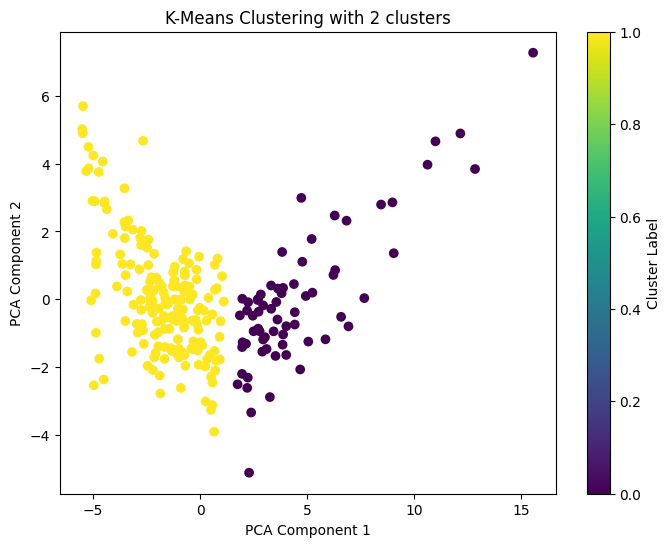

In [43]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe with the extracted HRV features (excluding 'record' and 'segment')

# Step 1: Data Preprocessing (Drop non-feature columns and normalize data)
X = df.drop(['record', 'segment'], axis=1)  # Remove non-feature columns
scaler = StandardScaler()  # Normalize data
X_scaled = scaler.fit_transform(X)

# Step 2: PCA (Dimensionality Reduction)
pca = PCA(n_components=2)  # Reduce to 2 components for visualization and clustering
X_pca = pca.fit_transform(X_scaled)

# Step 3: K-Means Clustering + Silhouette Score Evaluation
best_k = 2
best_score = -1

# Iterate over a range of cluster sizes
for k in range(2, 11):  # Number of clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=20, init='k-means++')
    labels = kmeans.fit_predict(X_pca)
    
    # Calculate Silhouette Score
    score = silhouette_score(X_pca, labels)
    print(f"Clusters: {k}, Silhouette Score: {score}")
    
    # Find the best score
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest number of clusters: {best_k} with Silhouette Score: {best_score}")

# Step 4: Visualize the results of the best K-Means clustering
best_kmeans = KMeans(n_clusters=best_k, random_state=42,n_init=20, init='k-means++')
best_labels = best_kmeans.fit_predict(X_pca)

# Plot the PCA results colored by the clustering labels
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis')
plt.title(f"K-Means Clustering with {best_k} clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


## Determine Optimal Clusters

Clusters: 2, Silhouette Score: 0.5197196749421064
Clusters: 3, Silhouette Score: 0.42174294497821074
Clusters: 4, Silhouette Score: 0.465676282373359
Clusters: 5, Silhouette Score: 0.37874135379897494
Clusters: 6, Silhouette Score: 0.3621732680528851
Clusters: 7, Silhouette Score: 0.3683318978890969
Clusters: 8, Silhouette Score: 0.378748357237698
Clusters: 9, Silhouette Score: 0.3730368719477745
Clusters: 10, Silhouette Score: 0.3345565330671312


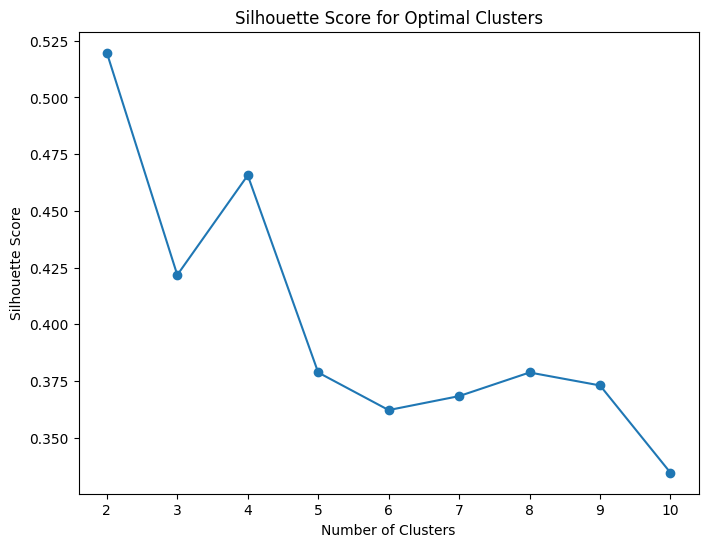

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Evaluate silhouette score for different clusters
sil_scores = []
for k in range(2, 11):  # We start from 2 clusters because silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    sil_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("Silhouette Score for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


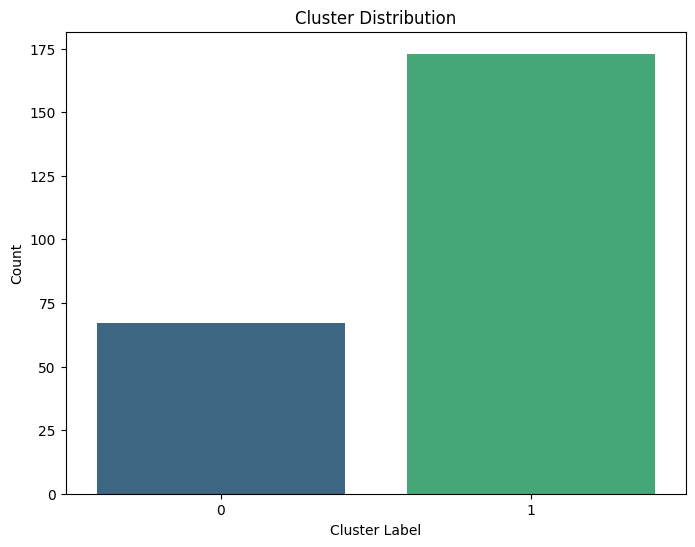

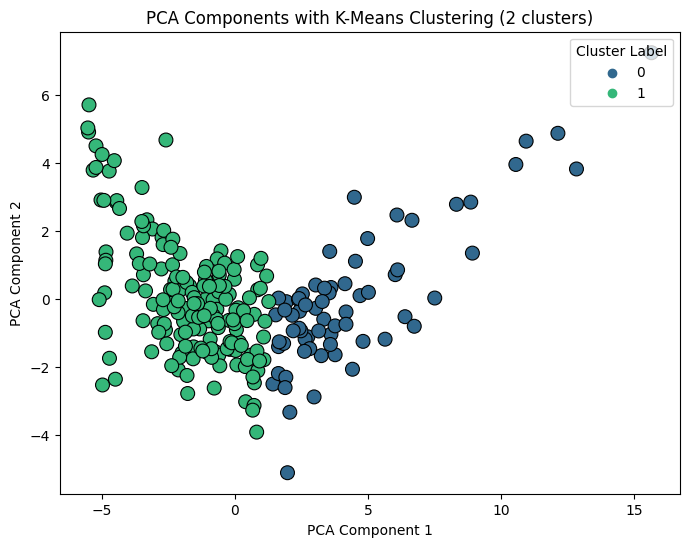

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your DataFrame has the cluster labels (from K-Means)
df['cluster_label'] = best_labels  # Assuming `best_labels` from the clustering step

# Visualizing the cluster distribution in terms of count
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster_label', data=df, palette="viridis")  # using color palette for better visualization
plt.title("Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()

# Scatter plot to show the PCA components and the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster_label'], palette='viridis', s=100, marker='o', edgecolor='black')
plt.title(f"PCA Components with K-Means Clustering ({best_k} clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster Label', loc='upper right')
plt.show()

# Check if any clusters are empty (if you need to avoid plotting empty clusters)
unique_clusters = df['cluster_label'].value_counts()
empty_clusters = unique_clusters[unique_clusters == 0]
if not empty_clusters.empty:
    print(f"Empty Clusters: {empty_clusters.index.tolist()}")


## SMOTE Oversampling

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Check the columns of the dataframe
print("Columns in the DataFrame:", df.columns)

# Separate features (X) and target (y)
drop_columns = ['record', 'segment', 'cluster_label']
if 'condition' in df.columns:
    drop_columns.append('condition')

X = df.drop(drop_columns, axis=1)  # Drop non-feature columns
y = df['cluster_label'].astype(int)  # Cluster labels as integer type

print(f'Features: {list(X.columns)}, \nTarget: {y.name}')

# Apply SMOTE before scaling
smote = SMOTE(random_state=101)
X_resampled, y_resampled = smote.fit_resample(X, y)  # Use raw X (before scaling)

# Scale AFTER SMOTE
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Convert back to DataFrame
df_resampled = pd.DataFrame(X_resampled_scaled, columns=X.columns)
df_resampled['cluster_label'] = y_resampled

# Check new class distribution after SMOTE
print("New class distribution after SMOTE:")
print(df_resampled['cluster_label'].value_counts())

Columns in the DataFrame: Index(['record', 'segment', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN',
       'vlf_power', 'lf_power', 'hf_power', 'lf_hf_ratio', 'total_power',
       'cluster_label'],
      dtype='object')
Features: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'vlf_power', 'lf_power', 'hf_power', 'lf_hf_ratio', 'total_power'], 
Target: cluster_label
New class distribution after SMOTE:
cluster_label
1    173
0    173
Name: count, dtype: int64


## Split Train and Test set with 30% for testing

In [22]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 24), (104, 24), (242,), (104,))

## Modeling

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Initialize XGBoost classifier
clf = XGBClassifier(verbosity=0)  # verbosity=0 silences output
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print Evaluation Results
print("\nEvaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Evaluation Metrics:
Accuracy: 0.9903846153846154
Precision: 0.9905660377358492
Recall: 0.9903846153846154
F1-score: 0.9903837263060564

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



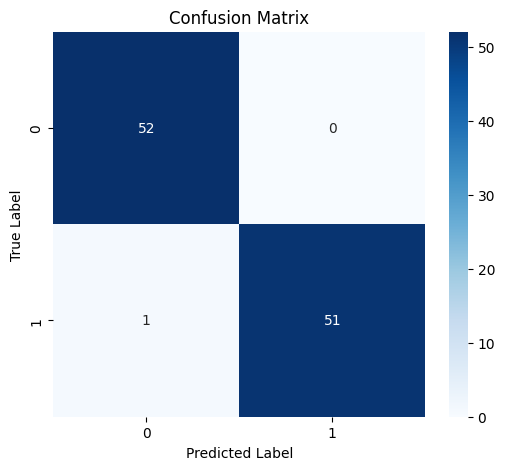

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Hyper Parameter With Grid Search

In [25]:
# from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# from sklearn.model_selection import GridSearchCV

# # Hyperparameter tuning with GridSearchCV
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [-1, 10, 20, 30],  # -1 means no limit in LightGBM
#     'num_leaves': [31, 50, 100],  # Controls complexity
#     'learning_rate': [0.01, 0.1, 0.2],  # Step size for boosting
#     'boosting_type': ['gbdt', 'dart'],  # Gradient boosting types
#     'class_weight': [None, 'balanced'],  # Handles imbalanced datasets
# }

# clf = LGBMClassifier(random_state=42, n_jobs=-1)
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Best model
# best_model = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)

# # Predictions
# y_pred_best = best_model.predict(X_test)

# # Evaluation Metrics
# accuracy = accuracy_score(y_test, y_pred_best)
# precision = precision_score(y_test, y_pred_best, average='weighted')
# recall = recall_score(y_test, y_pred_best, average='weighted')
# f1 = f1_score(y_test, y_pred_best, average='weighted')

# # Print Evaluation Results
# print("\nEvaluation Metrics:")
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

In [26]:
# Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_best)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

# Explainability AI

In [27]:
import shap

# Ensure X_test is a DataFrame (if it isn’t already)
# if not isinstance(X_test, pd.DataFrame):
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Use the unified API and provide a background (e.g., X_train)
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test_df, check_additivity=False)

# For binary classification, shap_values should be a list of two arrays:
print("SHAP values shape:", shap_values.values.shape)  # Expected (93, 19)

SHAP values shape: (104, 24)


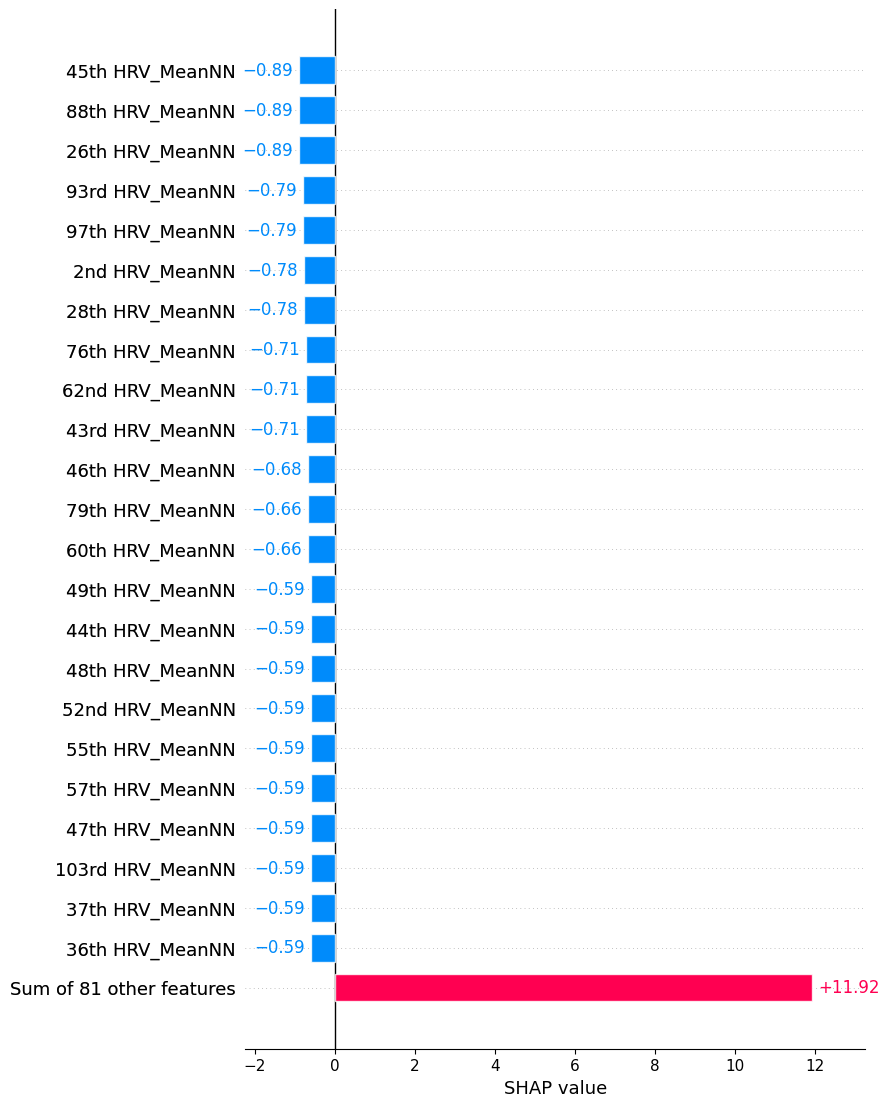

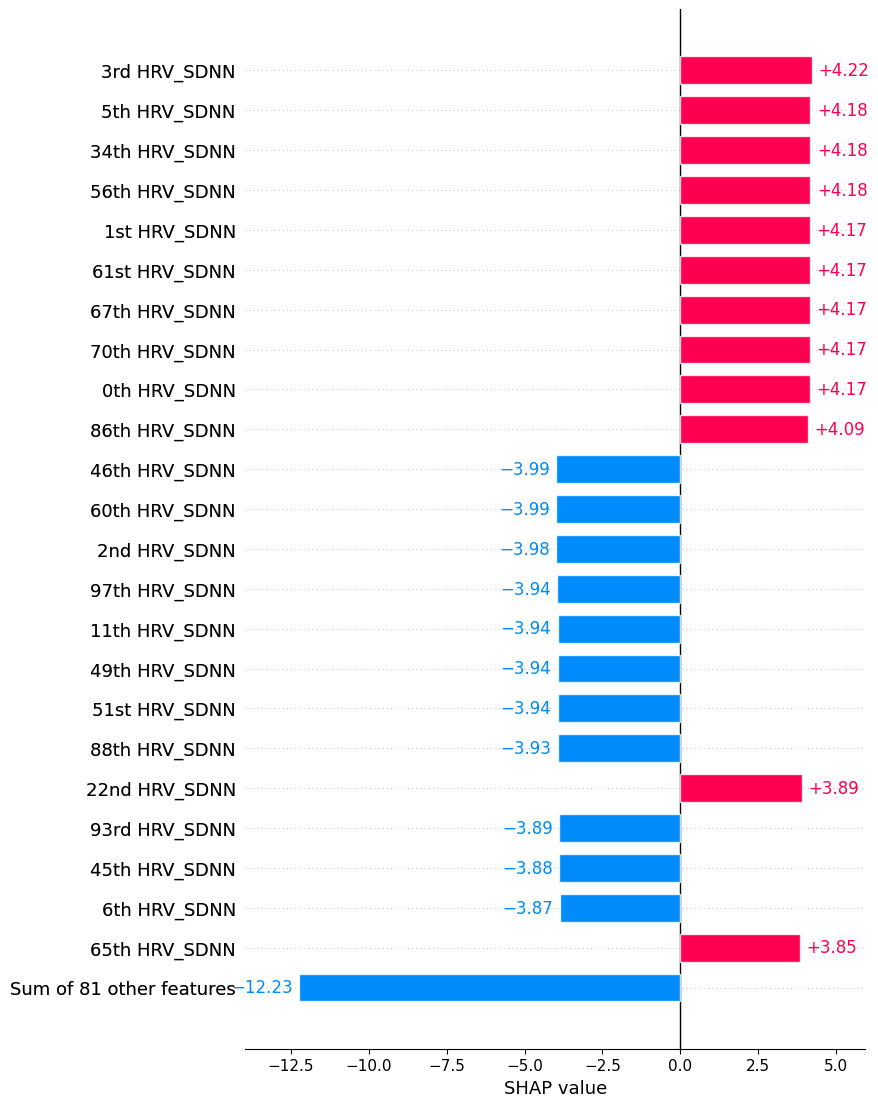

In [28]:
for i, class_name in enumerate(clf.classes_):
    shap_values_class = shap_values[:, i]  # Extract values for class 1
    shap.plots.bar(shap_values_class, max_display=X_test_df.shape[1])

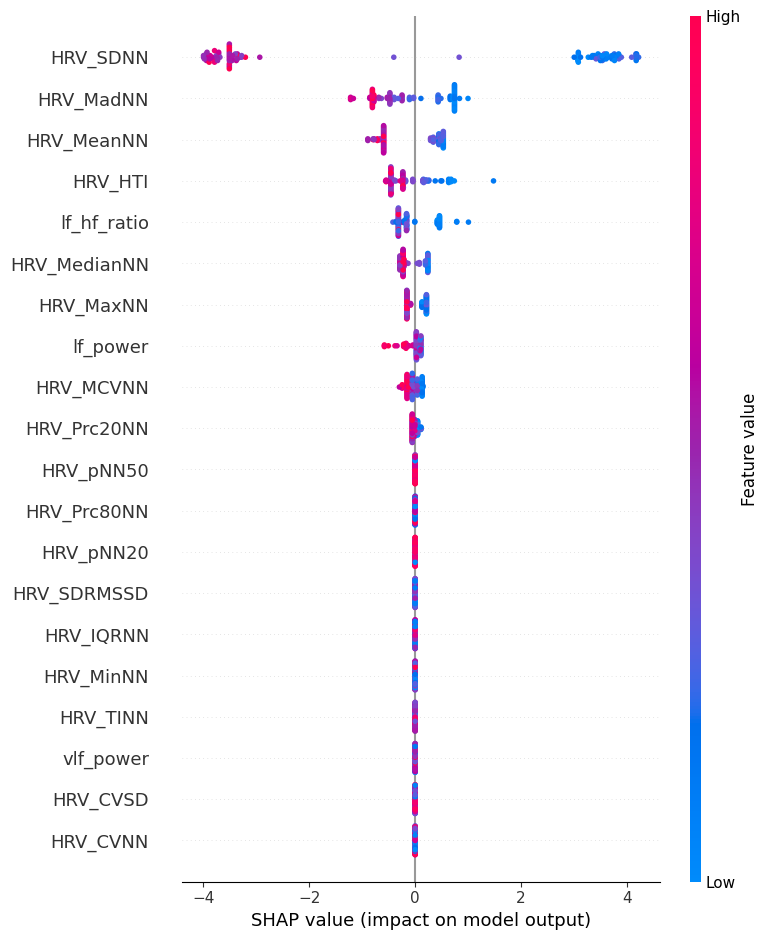

In [29]:
# Create a summary plot for the positive class
shap.summary_plot(shap_values, X_test_df)

In [30]:
print("Base values shape:", shap_values.base_values.shape)
print("SHAP values shape:", shap_values.values.shape)

Base values shape: (104,)
SHAP values shape: (104, 24)


In [31]:
shap.initjs()

# Select the first instance (index 0) and SHAP values for a specific class
instance_index = 0

shap.force_plot(
    shap_values.base_values[instance_index],  # Use only instance_index
    shap_values.values[instance_index],  
    X_test_df.iloc[instance_index],  
    feature_names=X_test_df.columns.tolist(),\
    # matplotlib = True
)

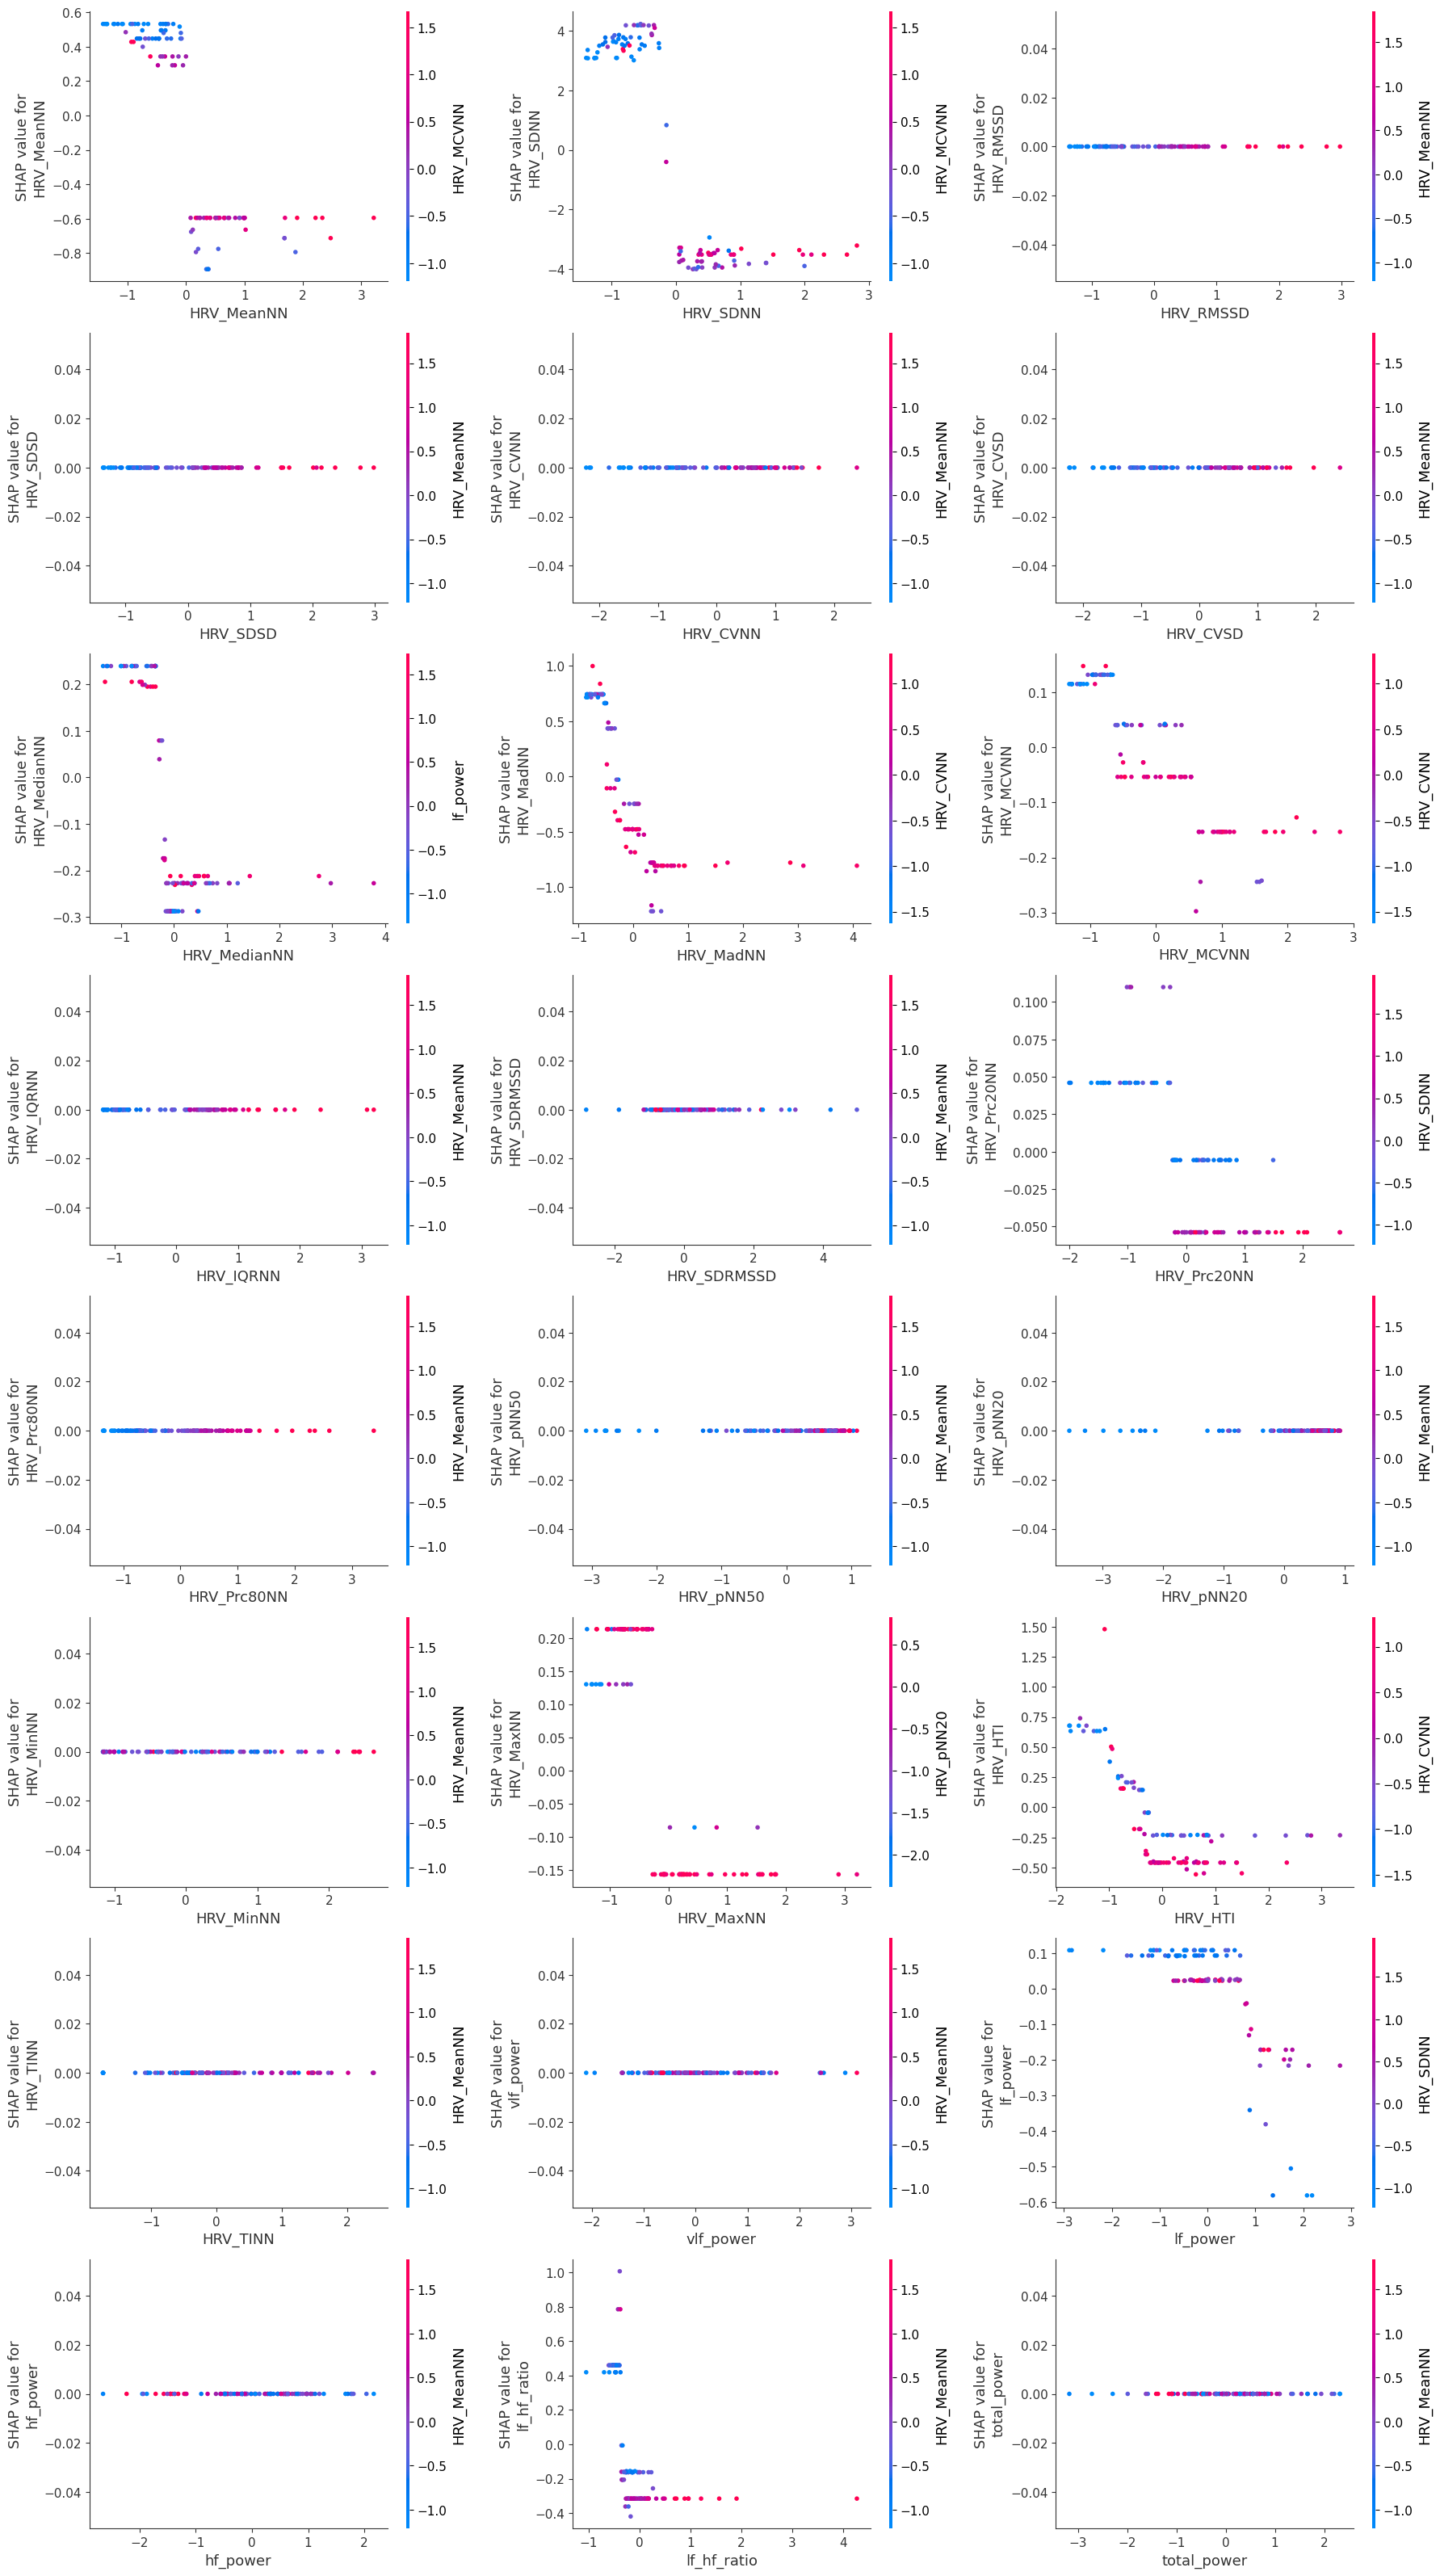

In [32]:
shap.initjs()  # Load JavaScript for visualization

# Define the number of columns per row
col_num = 3
rows_num = (len(X_test_df.columns) + col_num - 1) // col_num  # Calculate needed rows

fig, axes = plt.subplots(nrows=rows_num, ncols=col_num, figsize=(6 * col_num, 4 * rows_num))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Extract SHAP values for class 1 (modify if needed)
class_index = 1  # Set to 0 if you want to plot for class 0
shap_values_class = shap_values.values  # Shape (93, 19)

# Now this will work correctly:
for i, feature in enumerate(X_test_df.columns):
    shap.dependence_plot(feature, shap_values_class, X_test_df, ax=axes[i], show=False)


# Remove empty subplots if there are any extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Lime

## 1. Compare Multiple Instances

In [33]:
from lime import lime_tabular
import numpy as np

# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Convert to numpy array
    feature_names=X.columns.tolist(),
    class_names=clf.classes_,
    mode='classification',
    verbose=True,
    random_state=42
)

# Choose an instance to explain (e.g., first test sample)
instance_idx = 0
instance = X_test_df.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
exp = explainer.explain_instance(
    data_row=instance[0], 
    predict_fn=clf.predict_proba,  # Use probability predictions
    num_features=10,  # Show top 10 features
    top_labels=1  # Focus on most likely class
)

# Visualize
exp.show_in_notebook(show_table=True)

Intercept 0.39860711971769713
Prediction_local [0.9142279]
Right: 0.9936148


## 2. Force Plot Visualization

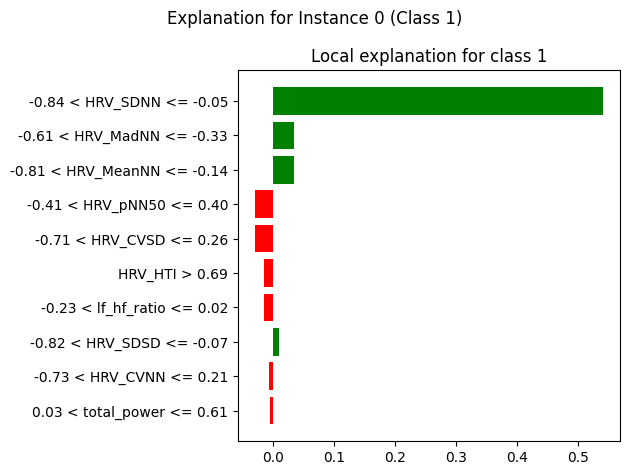

In [34]:
predicted_class_idx = np.argmax(clf.predict_proba(instance.reshape(1, -1)))

# Force plot fix
fig = exp.as_pyplot_figure(label=predicted_class_idx)
fig.suptitle(f'Explanation for Instance {instance_idx} (Class {predicted_class_idx})')
fig.tight_layout()

## 3. Feature Importance Summary